In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -q tensorflow-text

     |████████████████████████████████| 133kB 16.8MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


In [ ]:
!pip install -q tf-models-official

In [ ]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optmizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [ ]:
## Let's download and extract the dataset, then explore the directory structure.


url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [ ]:
dataset_dir

'./aclImdb'

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [ ]:
type(raw_train_ds), raw_train_ds, type(train_ds), train_ds

(tensorflow.python.data.ops.dataset_ops.BatchDataset,
 <BatchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int32)>,
 tensorflow.python.data.ops.dataset_ops.PrefetchDataset,
 <PrefetchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int32)>)

In [ ]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)
Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they

In [ ]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.7626284   0.9928099  -0.18611862  0.36673862  0.15233698  0.6550447
  0.9681154  -0.94862705  0.00216154 -0.98777324  0.0684273  -0.97630596]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946292  0.3432122   0.3323146  ...  0.2130091   0.7102076
  -0.05771127]
 [-0.28742066  0.31980988 -0.23018472 ...  0.58454984 -0.21329743
   0.7269208 ]
 [-0.6615696   0.688769   -0.87432975 ...  0.1087725  -0.26173288
   0.47855526]
 ...
 [-0.22561064 -0.28925598 -0.07064444 ...  0.4756608   0.832771
   0.40025362]
 [-0.2982425  -0.27473134 -0.05450555 ...  0.48849788  1.0955352
   0.18163432]
 [-0.44378024  0.00930739  0.07223781 ...  0.1729011   1.1833246
   0.0789801 ]]


In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.34178644]], shape=(1, 1), dtype=float32)


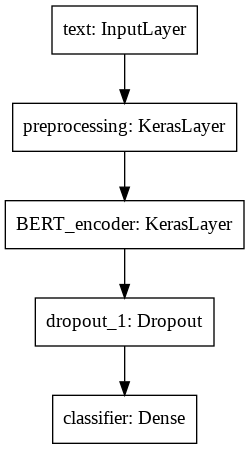

In [ ]:
tf.keras.utils.plot_model(classifier_model)

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
625/625 [==============================] - 162s 250ms/step - loss: 0.5761 - binary_accuracy: 0.6672 - val_loss: 0.3840 - val_binary_accuracy: 0.8342
Epoch 2/5
625/625 [==============================] - 152s 244ms/step - loss: 0.3615 - binary_accuracy: 0.8315 - val_loss: 0.3700 - val_binary_accuracy: 0.8448
Epoch 3/5
625/625 [==============================] - 152s 243ms/step - loss: 0.2767 - binary_accuracy: 0.8831 - val_loss: 0.3993 - val_binary_accuracy: 0.8500
Epoch 4/5
625/625 [==============================] - 152s 243ms/step - loss: 0.2135 - binary_accuracy: 0.9132 - val_loss: 0.4375 - val_binary_accuracy: 0.8484
Epoch 5/5
625/625 [==============================] - 152s 243ms/step - loss: 0.1616 - binary_accuracy: 0.9394 - val_loss: 0.4701 - val_binary_accuracy: 0.8496


In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 85s 108ms/step - loss: 0.4513 - binary_accuracy: 0.8561
Loss: 0.4512602984905243
Accuracy: 0.8561199903488159


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


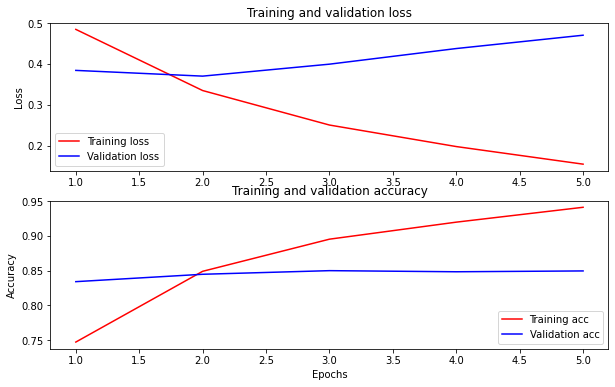

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
dataset_name = 'pretrained'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

In [ ]:
saved_model_path

'./pretrained_bert'

In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    ' Thank standing welcome Agenus Fourth Quarter 2020 Conference Webcast ',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input:  Thank standing welcome Agenus Fourth Quarter 2020 Conference Webcast  : score: 0.985048
input: The movie was great!           : score: 0.997771
input: The movie was meh.             : score: 0.953971
input: The movie was okish.           : score: 0.056793
input: The movie was terrible...      : score: 0.001090

Results from the model in memory:
input:  Thank standing welcome Agenus Fourth Quarter 2020 Conference Webcast  : score: 0.985048
input: The movie was great!           : score: 0.997771
input: The movie was meh.             : score: 0.953971
input: The movie was okish.           : score: 0.056793
input: The movie was terrible...      : score: 0.001090



In [ ]:
reloaded_results = tf.sigmoid(reloaded_model(tf.constant(df.text.tolist()[:5])))
original_results = tf.sigmoid(classifier_model(tf.constant(df.text.tolist()[:5])))

print('Results from the saved model:')
print_my_examples(df.text.tolist()[:5], reloaded_results)
print('Results from the model in memory:')
print_my_examples(df.text.tolist()[:5], original_results)

Results from the saved model:
input: Agenus Inc                     : score: 0.588320
input:  AGEN CEO Garo Armen Q4 2020 Results Earnings Transcript Mar : score: 0.297623
input:  15 2021 137 PM ETAgenus Inc   : score: 0.271904
input:  AGEN5 Comments Q4 2021 03 15 Earnings Summary EPS 0 : score: 0.374681
input: 20 beats 0                     : score: 0.980101

Results from the model in memory:
input: Agenus Inc                     : score: 0.588320
input:  AGEN CEO Garo Armen Q4 2020 Results Earnings Transcript Mar : score: 0.297623
input:  15 2021 137 PM ETAgenus Inc   : score: 0.271904
input:  AGEN5 Comments Q4 2021 03 15 Earnings Summary EPS 0 : score: 0.374681
input: 20 beats 0                     : score: 0.980101



In [ ]:
import pandas as pd

df = pd.read_csv('input.csv')
df = df.dropna(axis=0)
df.tail()

training_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(df['text'].values, tf.string),
            tf.cast(df['score'].values, tf.float32)
        )
    )
)

for features_tensor, target_tensor in training_dataset:
    print(f'features:{features_tensor} target:{target_tensor}')
    break


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,text,score
17773,Thank,0.944515
17774,Operator Thank,0.846527
17775,Ladies gentlemen concludes today conference,0.500000
17776,Thank participating,0.995314
17777,disconnect,0.001121


In [ ]:
train_size = int(0.7 * len(list(training_dataset)))
val_size = int(0.15 * len(list(training_dataset)))
test_size = int(0.15 * len(list(training_dataset)))

#full_dataset = tf.data.TFRecordDataset(training_dataset)
training_dataset = training_dataset.shuffle(1000)
train_dataset = training_dataset.take(train_size)
test_dataset = training_dataset.skip(train_size)
val_dataset = training_dataset.skip(val_size)
test_dataset = training_dataset.take(test_size)

['Agenus Inc',
 ' AGEN CEO Garo Armen Q4 2020 Results Earnings Transcript Mar',
 ' 15 2021 137 PM ETAgenus Inc',
 ' AGEN5 Comments Q4 2021 03 15 Earnings Summary EPS 0',
 '20 beats 0']

In [ ]:
history = classifier_model.fit(x=train_ds, validation_data=val_ds, epochs=epochs)

In [ ]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    ' Thank standing welcome Agenus Fourth Quarter 2020 Conference Webcast ',  # this is the same sentence tried earlier
    'disconnect',
    'Jan Medina Thanks Liz thank joining today'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input:  Thank standing welcome Agenus Fourth Quarter 2020 Conference Webcast  : score: 0.985048
input: disconnect                     : score: 0.423640
input: Jan Medina Thanks Liz thank joining today : score: 0.997239

Results from the model in memory:
input:  Thank standing welcome Agenus Fourth Quarter 2020 Conference Webcast  : score: 0.985048
input: disconnect                     : score: 0.423640
input: Jan Medina Thanks Liz thank joining today : score: 0.997239



In [ ]:
import boto3

In [ ]:
session = boto3.Session(aws_access_key_id='bla' , aws_secret_access_key='bla',    
                        region_name='us-east-1')
s3 = session.resource('s3')
bucket = s3.Bucket("bertmodel")
for subdir, dirs, files in os.walk(saved_model_path):
   print(subdir, dirs, files)
   for file in files:
      full_path = os.path.join(subdir, file)
      print(full_path)
      with open(full_path, 'rb') as data:
          bucket.put_object(Key=full_path[len(saved_model_path):], Body=data)

./pretrained_bert ['variables', 'assets'] ['saved_model.pb']
./pretrained_bert/saved_model.pb
./pretrained_bert/variables [] ['variables.index', 'variables.data-00000-of-00001']
./pretrained_bert/variables/variables.index
./pretrained_bert/variables/variables.data-00000-of-00001
./pretrained_bert/assets [] ['vocab.txt']
./pretrained_bert/assets/vocab.txt


In [ ]:
import boto3
import os 

def downloadDirectoryFroms3(bucketName, remoteDirectoryName):
    s3_resource = boto3.resource('s3', aws_access_key_id='bla' , aws_secret_access_key='bla')
    bucket = s3_resource.Bucket("bertmodel") 
    for obj in bucket.objects.filter(Prefix = remoteDirectoryName):
        if not os.path.exists(os.path.dirname(obj.key)):
            os.makedirs(os.path.dirname(obj.key))
        bucket.download_file(obj.key, obj.key) # save to same path

In [ ]:
downloadDirectoryFroms3("bertmodel", "./content/myModel")

In [ ]:
import boto3
import os 

# set aws credentials 
s3r = boto3.resource('s3', aws_access_key_id='bla' , aws_secret_access_key='bla')
bucket = s3r.Bucket('bertmodel')

# downloading folder 
prefix = 'model'
for object in bucket.objects.filter(Prefix = '/'):
    print(object.key, prefix)
    if object.key == prefix:
        print('in')
        os.makedirs(os.path.dirname(object.key), exist_ok=True)
        continue;
    os.chdir('/content')
    bucket.download_file(object.key, object.key)

/assets/vocab.txt model
/saved_model.pb model
/variables/variables.data-00000-of-00001 model
/variables/variables.index model


In [ ]:
tf.saved_model.save(classifier_model, export_dir='./model')